In [1]:
!pip install mlflow openpyxl

  Using cached mlflow-3.10.0-py3-none-any.whl.metadata (31 kB)
Using cached mlflow-3.10.0-py3-none-any.whl (10.2 MB)


1. Function to create synthetic data – please do not change

In [2]:
import numpy as np
from sklearn.datasets import make_blobs, make_moons
import matplotlib.pyplot as plt

def create_data(the_noise, n1_samples, n2_samples, n3_samples, n4_samples):
  X_1, y_1 = make_blobs(
    n_samples=n1_samples,
    centers=4,
    random_state=42)

  X_2, y_2 = make_moons(
      n_samples=n2_samples,
      noise=the_noise,
      random_state=42
  )

  X_2[:, 0] += 10
  X_2[:, 1] += 10

  rng = np.random.RandomState(42)
  angles = rng.rand(n3_samples) * 2 * np.pi
  r = 5.0 + rng.randn(n3_samples) * the_noise
  X_3 = np.column_stack((r * np.cos(angles), r * np.sin(angles)))
  X_3[:, 0] += 20

  X = np.vstack((X_1, X_2, X_3))
  return X

2. Call create_data and visualize the data

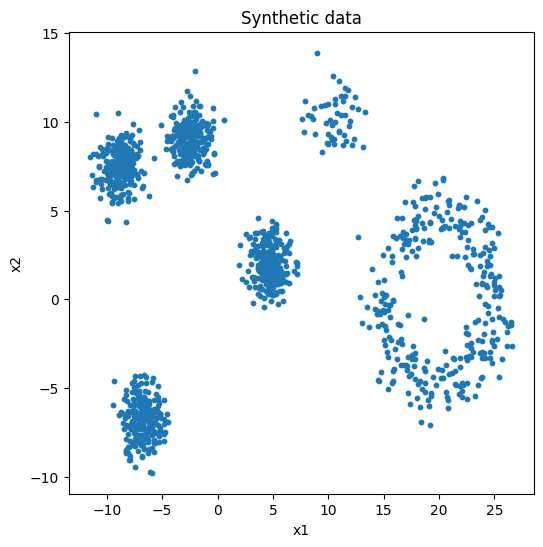

In [3]:
X = create_data(1.0, 1000, 50, 300, 200)

plt.figure(figsize=(6,6))
plt.scatter(X[:,0], X[:,1], s=10)
plt.title("Synthetic data")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

3. Train KMeans – choose number of clusters using Silhouette

Best k (KMeans): 6
Best silhouette: 0.7251181630059241


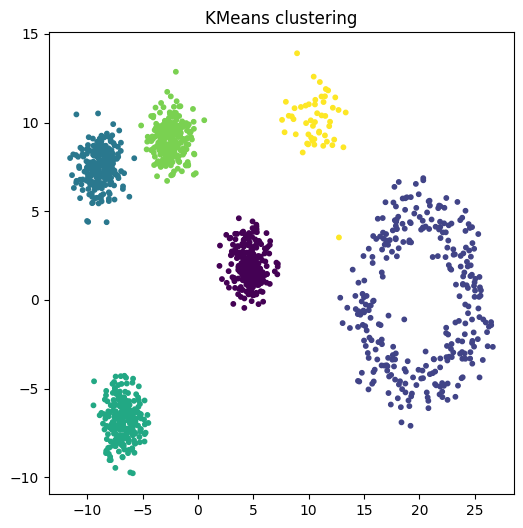

In [4]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sil_scores = []
K_range = range(2, 10)

for k in K_range:
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = model.fit_predict(X)
    score = silhouette_score(X, labels)
    sil_scores.append(score)

best_k = K_range[np.argmax(sil_scores)]
print("Best k (KMeans):", best_k)
print("Best silhouette:", max(sil_scores))

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X)

plt.figure(figsize=(6,6))
plt.scatter(X[:,0], X[:,1], c=kmeans_labels, s=10)
plt.title("KMeans clustering")
plt.show()

4. Train Agglomerative Clustering

Best k (Agglomerative): 6
Best silhouette: 0.7256900714288006


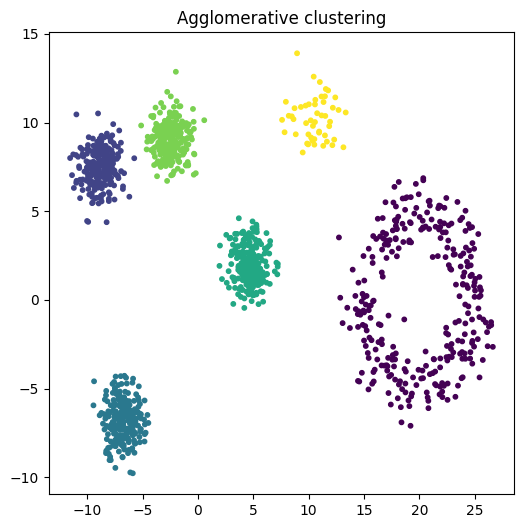

In [5]:
from sklearn.cluster import AgglomerativeClustering

agg_scores = []

for k in K_range:
    model = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = model.fit_predict(X)
    score = silhouette_score(X, labels)
    agg_scores.append(score)

best_k_agg = K_range[np.argmax(agg_scores)]
print("Best k (Agglomerative):", best_k_agg)
print("Best silhouette:", max(agg_scores))

agg = AgglomerativeClustering(n_clusters=best_k_agg, linkage='ward')
agg_labels = agg.fit_predict(X)

plt.figure(figsize=(6,6))
plt.scatter(X[:,0], X[:,1], c=agg_labels, s=10)
plt.title("Agglomerative clustering")
plt.show()

5. Train DBSCAN

Best DBSCAN params: (0.5, 10)
Best DBSCAN silhouette: 0.8250306230416449


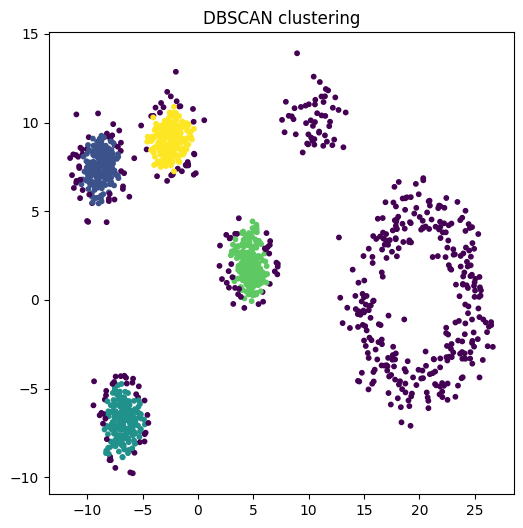

In [6]:
from sklearn.cluster import DBSCAN

eps_values = [0.3, 0.5, 0.8, 1.0, 1.5]
min_samples_values = [5, 10]

best_score = -1
best_params = None
best_labels = None

for eps in eps_values:
    for ms in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=ms)
        labels = db.fit_predict(X)

        unique = set(labels)
        if len(unique) <= 1 or (len(unique) == 2 and -1 in unique):
            continue

        mask = labels != -1
        score = silhouette_score(X[mask], labels[mask])

        if score > best_score:
            best_score = score
            best_params = (eps, ms)
            best_labels = labels

print("Best DBSCAN params:", best_params)
print("Best DBSCAN silhouette:", best_score)

plt.figure(figsize=(6,6))
plt.scatter(X[:,0], X[:,1], c=best_labels, s=10)
plt.title("DBSCAN clustering")
plt.show()

6. Compare results

In [7]:
print("KMeans best silhouette:", max(sil_scores))
print("Agglomerative best silhouette:", max(agg_scores))
print("DBSCAN best silhouette:", best_score)

if max(sil_scores) > max(agg_scores) and max(sil_scores) > best_score:
    print("Best method: KMeans")
elif max(agg_scores) > best_score:
    print("Best method: Agglomerative")
else:
    print("Best method: DBSCAN")

KMeans best silhouette: 0.7251181630059241
Agglomerative best silhouette: 0.7256900714288006
DBSCAN best silhouette: 0.8250306230416449
Best method: DBSCAN


Part B – MLflow experiments and Excel export

In [8]:
import mlflow
import pandas as pd

mlflow.set_tracking_uri("file:///content/mlruns")
mlflow.set_experiment("clustering_ex3")

all_results = []

/usr/local/lib/python3.12/dist-packages/mlflow/tracking/_tracking_service/utils.py:184: FutureWarning: The filesystem tracking backend (e.g., './mlruns') is deprecated as of February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://mlflow.org/docs/latest/self-hosting/migrate-from-file-store for migration guidance.
  return FileStore(store_uri, store_uri)
2026/02/22 20:05:23 INFO mlflow.tracking.fluent: Experiment with name 'clustering_ex3' does not exist. Creating a new experiment.


In [9]:
for k in range(2, 7):
    with mlflow.start_run(run_name=f"KMeans_k_{k}"):
        model = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = model.fit_predict(X)
        score = silhouette_score(X, labels)

        mlflow.log_param("algorithm", "KMeans")
        mlflow.log_param("n_clusters", k)
        mlflow.log_metric("silhouette", score)

        all_results.append({
            "algorithm": "KMeans",
            "n_clusters": k,
            "eps": None,
            "min_samples": None,
            "silhouette": score
        })

In [10]:
for k in range(2, 7):
    with mlflow.start_run(run_name=f"Agglomerative_k_{k}"):
        model = AgglomerativeClustering(n_clusters=k, linkage="ward")
        labels = model.fit_predict(X)
        score = silhouette_score(X, labels)

        mlflow.log_param("algorithm", "Agglomerative")
        mlflow.log_param("n_clusters", k)
        mlflow.log_metric("silhouette", score)

        all_results.append({
            "algorithm": "Agglomerative",
            "n_clusters": k,
            "eps": None,
            "min_samples": None,
            "silhouette": score
        })

In [11]:
eps_list = [0.4, 0.6, 0.8]
min_samples_list = [5, 10]

for eps in eps_list:
    for ms in min_samples_list:
        with mlflow.start_run(run_name=f"DBSCAN_eps_{eps}_ms_{ms}"):
            model = DBSCAN(eps=eps, min_samples=ms)
            labels = model.fit_predict(X)

            unique = set(labels)
            if len(unique) <= 1 or (len(unique) == 2 and -1 in unique):
                continue

            mask = labels != -1
            score = silhouette_score(X[mask], labels[mask])

            mlflow.log_param("algorithm", "DBSCAN")
            mlflow.log_param("eps", eps)
            mlflow.log_param("min_samples", ms)
            mlflow.log_metric("silhouette", score)

            all_results.append({
                "algorithm": "DBSCAN",
                "n_clusters": None,
                "eps": eps,
                "min_samples": ms,
                "silhouette": score
            })

In [12]:
df = pd.DataFrame(all_results)
df

,algorithm,n_clusters,eps,min_samples,silhouette
0,KMeans,2.0,NaN,NaN,0.567259
1,KMeans,3.0,NaN,NaN,0.585790
2,KMeans,4.0,NaN,NaN,0.681319
3,KMeans,5.0,NaN,NaN,0.697614
4,KMeans,6.0,NaN,NaN,0.725118
5,Agglomerative,2.0,NaN,NaN,0.569846
6,Agglomerative,3.0,NaN,NaN,0.580623
7,Agglomerative,4.0,NaN,NaN,0.681264
8,Agglomerative,5.0,NaN,NaN,0.697786
9,Agglomerative,6.0,NaN,NaN,0.725690


In [13]:
excel_path = "clustering_experiments.xlsx"
df.to_excel(excel_path, index=False)
excel_path

'clustering_experiments.xlsx'

In [14]:
df.sort_values(by="silhouette", ascending=False).head(1)

,algorithm,n_clusters,eps,min_samples,silhouette
11,DBSCAN,NaN,0.4,10.0,0.849836


We ran multiple experiments for KMeans, Agglomerative Clustering and DBSCAN.
Each experiment was tracked using MLflow and evaluated using the silhouette score.
The best configuration was selected according to the highest silhouette score.